In [2]:
import sys
import torch
import numpy as np
import scipy.signal
from torchvision.io import read_image
import torch.nn as nn
import torchvision 
from torchvision import transforms 
from torch.utils.data import Subset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
from torchvision import transforms 

In [4]:
image_path = './'
transform = transforms.Compose([transforms.ToTensor()])

mnist_dataset = torchvision.datasets.MNIST(root=image_path, 
                                           train=True, 
                                           transform=transform, 
                                           download=True)

mnist_valid_dataset = Subset(mnist_dataset, torch.arange(10000)) 
mnist_train_dataset = Subset(mnist_dataset, torch.arange(10000, len(mnist_dataset)))
mnist_test_dataset = torchvision.datasets.MNIST(root=image_path, 
                                           train=False, 
                                           transform=transform, 
                                           download=False)

In [5]:
batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset, batch_size, shuffle=False)

In [6]:
batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset, batch_size, shuffle=False)

model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2))
model.add_module('relu1', nn.ReLU())        
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))   
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))
model.add_module('relu2', nn.ReLU())        
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))      

x = torch.ones((4, 1, 28, 28))
model(x).shape




model.add_module('flatten', nn.Flatten()) 

x = torch.ones((4, 1, 28, 28))
model(x).shape




model.add_module('fc1', nn.Linear(3136, 1024)) 
model.add_module('relu3', nn.ReLU()) 
model.add_module('dropout', nn.Dropout(p=0.5)) 

model.add_module('fc2', nn.Linear(1024, 10)) 




#device = torch.device("cuda:0")
device = torch.device("cpu")

model = model.to(device) 

In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device) 
            y_batch = y_batch.to(device) 
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device) 
                y_batch = y_batch.to(device) 
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float() 
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [9]:
torch.manual_seed(1)
num_epochs = 20
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.9490 val_accuracy: 0.9803
Epoch 2 accuracy: 0.9844 val_accuracy: 0.9853
Epoch 3 accuracy: 0.9889 val_accuracy: 0.9872
Epoch 4 accuracy: 0.9913 val_accuracy: 0.9853
Epoch 5 accuracy: 0.9926 val_accuracy: 0.9891
Epoch 6 accuracy: 0.9950 val_accuracy: 0.9893
Epoch 7 accuracy: 0.9950 val_accuracy: 0.9877
Epoch 8 accuracy: 0.9958 val_accuracy: 0.9886
Epoch 9 accuracy: 0.9961 val_accuracy: 0.9892
Epoch 10 accuracy: 0.9970 val_accuracy: 0.9904
Epoch 11 accuracy: 0.9967 val_accuracy: 0.9877
Epoch 12 accuracy: 0.9974 val_accuracy: 0.9921
Epoch 13 accuracy: 0.9978 val_accuracy: 0.9886
Epoch 14 accuracy: 0.9974 val_accuracy: 0.9908
Epoch 15 accuracy: 0.9975 val_accuracy: 0.9911
Epoch 16 accuracy: 0.9982 val_accuracy: 0.9923
Epoch 17 accuracy: 0.9985 val_accuracy: 0.9907
Epoch 18 accuracy: 0.9986 val_accuracy: 0.9906
Epoch 19 accuracy: 0.9977 val_accuracy: 0.9911
Epoch 20 accuracy: 0.9985 val_accuracy: 0.9896


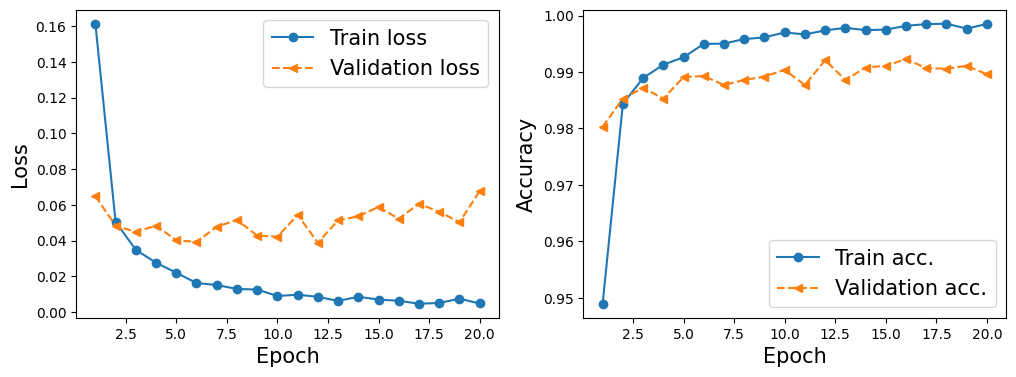

In [10]:
x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/14_13.png')
plt.show()


In [12]:
model_cpu = model.cpu()
pred = model(mnist_test_dataset.data.unsqueeze(1) / 255.)
is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets).float()
print(f'Test accuracy: {is_correct.mean():.4f}') 




fig = plt.figure(figsize=(12, 4))

Test accuracy: 0.9919


<Figure size 1200x400 with 0 Axes>

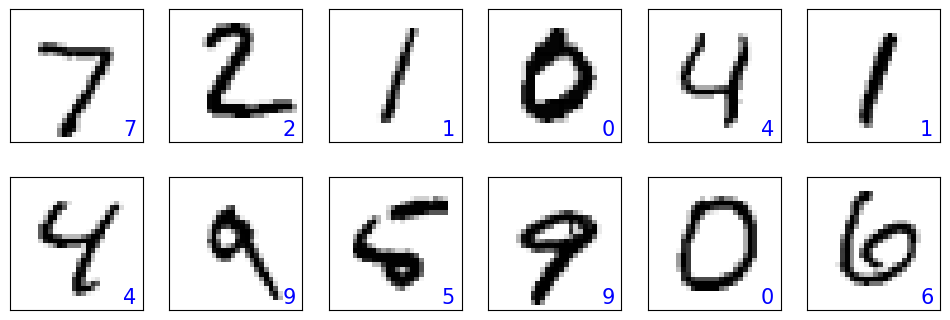

In [14]:
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = mnist_test_dataset[i][0][0, :, :]
    pred = model(img.unsqueeze(0).unsqueeze(1))
    y_pred = torch.argmax(pred)
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, y_pred.item(), 
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center', 
            transform=ax.transAxes)
    
    
#plt.savefig('figures/14_14.png')
plt.show()





if not os.path.exists('models'):
    os.mkdir('models')

path = 'models/mnist-cnn.ph'
torch.save(model, path)